In [43]:
import pandas as pd
import numpy as np
import joblib
import json
from collections import Counter
from numpy import argmax
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import (
    train_test_split, 
    cross_validate, 
    KFold, 
    GridSearchCV
)
from sklearn.preprocessing import StandardScaler, OneHotEncoder 
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    roc_auc_score,
    confusion_matrix, 
    ConfusionMatrixDisplay,
    roc_curve, 
    auc, 
    precision_recall_curve
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import (
    RandomForestClassifier, 
    GradientBoostingClassifier, 
    AdaBoostClassifier
)
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

In [2]:
# Leo la data cruda
path= "dataset_alpha_betha.csv"
df = pd.read_csv(path)

In [3]:
#resumen de nulos y variables
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   autoID            7043 non-null   object 
 1   SeniorCity        7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   Service1          7043 non-null   object 
 5   Service2          7043 non-null   object 
 6   Security          7043 non-null   object 
 7   OnlineBackup      7043 non-null   object 
 8   DeviceProtection  7043 non-null   object 
 9   TechSupport       7043 non-null   object 
 10  Contract          7043 non-null   object 
 11  PaperlessBilling  7043 non-null   object 
 12  PaymentMethod     7043 non-null   object 
 13  Charges           7043 non-null   float64
 14  Demand            7043 non-null   object 
 15  Class             7043 non-null   object 
dtypes: float64(1), int64(1), object(14)
memory

In [4]:
#conteo de clases
df['Class'].value_counts(normalize=True)

Class
Alpha    0.73463
Betha    0.26537
Name: proportion, dtype: float64

In [5]:
# Convierto variables a uméricos o objetos segun necesidad
df['Charges'] = pd.to_numeric(df['Charges'], errors='coerce')
df['Demand'] = pd.to_numeric(df['Demand'], errors='coerce')
df['SeniorCity'] = df['SeniorCity'].astype('object')


In [6]:
#Elimino filas de nulos ya que son pocas
df.dropna(inplace=True)

In [7]:
# Guardo ID y variable objetivo
id_column = df['autoID']
y = df['Class'].map({'Alpha': 1, 'Betha': 0})  # variable objetivo (Alpha / Beta)

# Variables predictoras: quito ID y la clase
X = df.drop(columns=['autoID', 'Class'])

# One-Hot Encoding para categóricas
X = pd.get_dummies(X, drop_first=True)


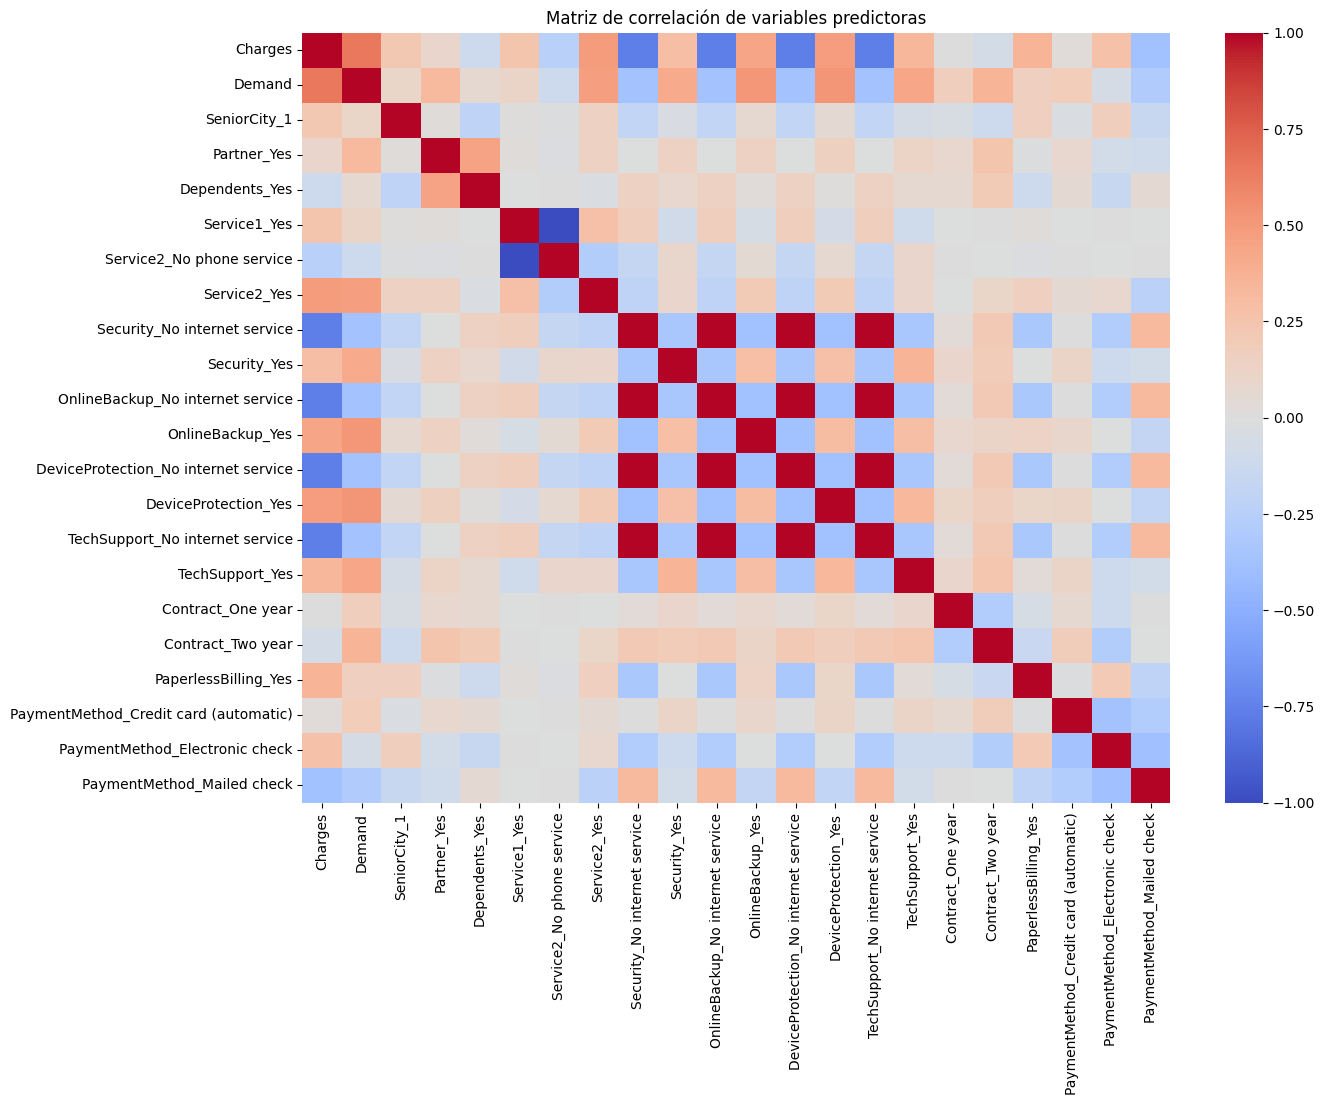

In [8]:
# Análisis de correlación
# Calculo matriz de correlación
corr_matrix = X.corr()

# Heatmap 
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=False)
plt.title('Matriz de correlación de variables predictoras')
plt.show()


In [9]:
# Elimino variables con alta correlación

cols_to_drop = [
    'Security_No internet service',
    'OnlineBackup_No internet service',
    'DeviceProtection_No internet service',
    'Service2_No phone service'
]

X = X.drop(columns=cols_to_drop, errors='ignore')


<Axes: >

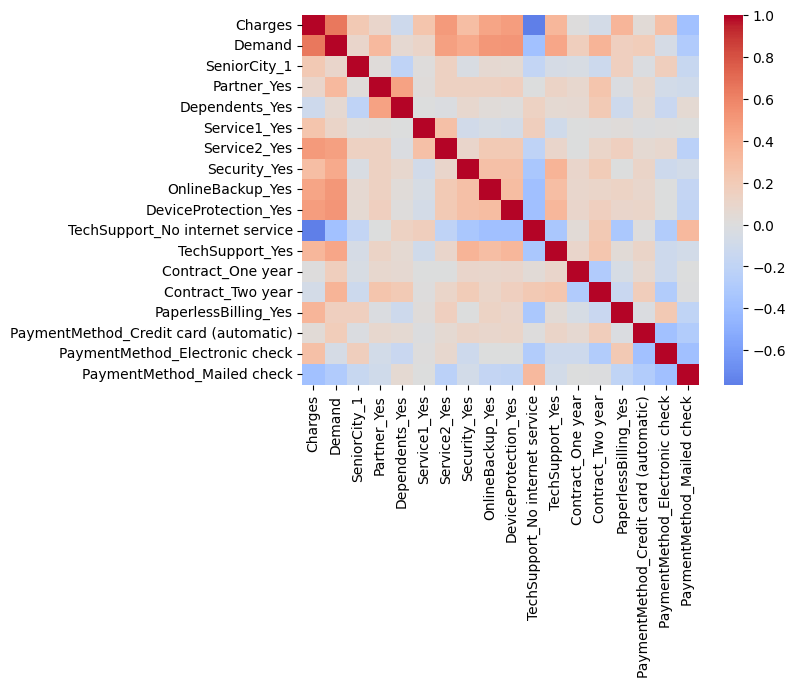

In [10]:
#Me aseguro de que no queden correlaciones muy altas para evitar problemas de multicolinealidad
corr = X.corr()
sns.heatmap(corr, cmap='coolwarm', center=0)


Modelado

In [11]:
# Divido los datos en Train, Validation y Test con estratificación
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp
)

# Escalo con el conjunto de entrenamiento
scaler = StandardScaler()




X_train[['Charges', 'Demand']] = scaler.fit_transform(X_train[['Charges', 'Demand']])
X_val[['Charges', 'Demand']] = scaler.transform(X_val[['Charges', 'Demand']])
X_test[['Charges', 'Demand']] = scaler.transform(X_test[['Charges', 'Demand']])

# Verificación rápida
print(f"Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")


# Función para imprimir la distribución de clases
def print_class_distribution(y_set, name):
    counts = y_set.value_counts().sort_index()
    total = len(y_set)
    # Calcular porcentajes para verificar el estratificado
    perc_0 = counts[0] / total * 100 if 0 in counts.index else 0
    perc_1 = counts[1] / total * 100 if 1 in counts.index else 0
    
    print(f"\nDistribución de Clases en {name}:")
    print(f"Clase 0 (Betha): {counts.get(0, 0)} ({perc_0:.2f}%)")
    print(f"Clase 1 (Alpha): {counts.get(1, 0)} ({perc_1:.2f}%)")

# Mostrar distribución para cada conjunto
print_class_distribution(y_train, "ENTRENAMIENTO (Train)")
print_class_distribution(y_val, "VALIDACIÓN (Validation)")
print_class_distribution(y_test, "PRUEBA (Test)")

Train: (5062, 18), Validation: (1266, 18), Test: (704, 18)

Distribución de Clases en ENTRENAMIENTO (Train):
Clase 0 (Betha): 1345 (26.57%)
Clase 1 (Alpha): 3717 (73.43%)

Distribución de Clases en VALIDACIÓN (Validation):
Clase 0 (Betha): 337 (26.62%)
Clase 1 (Alpha): 929 (73.38%)

Distribución de Clases en PRUEBA (Test):
Clase 0 (Betha): 187 (26.56%)
Clase 1 (Alpha): 517 (73.44%)


In [12]:
#Comparación de Modelos Base (Corregida con cross_validate)

# Definición de modelos
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "KNN": KNeighborsClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Definición de métricas a evaluar
scoring = ['accuracy', 'roc_auc', 'recall', 'precision', 'f1']

# Configuración de KFold (5-folds)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

metricas_modelos_list = []

print("Iniciando evaluación de modelos con cross_validate (5 folds)...")

# ¡CAMBIO CLAVE! Usamos X_train y y_train (datos escalados)
# para evitar Data Leakage y ser consistente con el resto del pipeline.
X_base = X_train
y_base = y_train

for nombre, modelo in models.items():
    
    # Usamos cross_validate para obtener todas las métricas en una sola ejecución
    cv_results = cross_validate(
        modelo, 
        X_base, 
        y_base, 
        cv=kf, 
        scoring=scoring, 
        n_jobs=-1,
        return_train_score=False # No necesitamos el score de entrenamiento aquí
    )
    
    # Almacenar el promedio de cada métrica
    metricas_modelos_list.append({
        'Modelo': nombre,
        # Se usa 'test_' como prefijo para las métricas de prueba del fold
        'Accuracy': cv_results['test_accuracy'].mean(),
        'AUC': cv_results['test_roc_auc'].mean(),
        'Recall': cv_results['test_recall'].mean(),
        'Precision': cv_results['test_precision'].mean(),
        'F1': cv_results['test_f1'].mean()
    })
    
    print(f"Evaluado: {nombre}")

# DF
df_comparacion = pd.DataFrame(metricas_modelos_list)

# Ordenar por F1 Score
df_comparacion = df_comparacion.sort_values(by='F1', ascending=False)

print("\n=== Resultados de la Comparación de Modelos (Promedio CV en Entrenamiento) ===")
print(df_comparacion)

Iniciando evaluación de modelos con cross_validate (5 folds)...
Evaluado: Logistic Regression
Evaluado: Decision Tree
Evaluado: Random Forest
Evaluado: Gradient Boosting
Evaluado: AdaBoost
Evaluado: KNN
Evaluado: XGBoost

=== Resultados de la Comparación de Modelos (Promedio CV en Entrenamiento) ===
                Modelo  Accuracy       AUC    Recall  Precision        F1
0  Logistic Regression  0.805807  0.841226  0.900230   0.845388  0.871857
4             AdaBoost  0.805215  0.846256  0.896162   0.847345  0.870991
3    Gradient Boosting  0.799090  0.844606  0.910140   0.832033  0.869246
2        Random Forest  0.785461  0.811635  0.899474   0.824471  0.860213
6              XGBoost  0.775386  0.810778  0.872863   0.830213  0.850836
5                  KNN  0.761755  0.771191  0.851054   0.829273  0.839801
1        Decision Tree  0.720071  0.649167  0.801735   0.814255  0.807840


In [13]:
# Balanceo el Conjunto de Entrenamiento 

#  SMOTE
smote = SMOTE(random_state=42)
print("Distribución de clases antes de SMOTE:", Counter(y_train))

# Aplico SMOTE SOLAMENTE al conjunto de entrenamiento
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print("Distribución de clases después de SMOTE:", Counter(y_train_resampled))
print(f"Dimensiones de X_train_resampled: {X_train_resampled.shape}")

Distribución de clases antes de SMOTE: Counter({1: 3717, 0: 1345})
Distribución de clases después de SMOTE: Counter({1: 3717, 0: 3717})
Dimensiones de X_train_resampled: (7434, 18)


In [14]:
# %% ==========================================
# 🔧 Ajuste de hiperparámetros con GridSearchCV (Logistic Regression) - Búsqueda Ampliada
# ==========================================

# Definimos el modelo base: Regresión Logística
# Usamos un solver que soporte múltiples penalties (solver='saga' o 'liblinear')
# Aumentamos max_iter para asegurar la convergencia en grids grandes
base_model_lr = LogisticRegression(random_state=42, max_iter=10000)

# 1. Definimos la grilla de hiperparámetros AMPLIADA
# Total combinaciones: 7 (C) * 3 (penalty) * 4 (solver) = 84 combinaciones
param_grid_ampliada_lr = {
    # 7 valores de C, desde muy poca regularización (0.0001) a muy fuerte (1000)
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],  
    # Tipos de regularización
    'penalty': ['l1', 'l2'], 
    # Solvers que soportan L1/L2 (saga puede ser lento, pero es potente)
    'solver': ['liblinear', 'saga'] 
}

# 2. Configuramos el grid search
# Total fits: 84 combinaciones * 5 folds = 420 fits
grid_lr = GridSearchCV(
    estimator=base_model_lr,
    param_grid=param_grid_ampliada_lr, 
    scoring='f1',           # Usamos F1 como métrica objetivo
    cv=5,                   # 5-fold cross-validation
    n_jobs=-1,
    verbose=2               # Más detalles de la ejecución
)

# 3. Entrenamiento: con datos rebalanceados
print(f"Iniciando búsqueda de hiperparámetros: {len(param_grid_ampliada_lr['C']) * len(param_grid_ampliada_lr['penalty']) * len(param_grid_ampliada_lr['solver'])} combinaciones * 5 folds = 420 fits...")
grid_lr.fit(X_train_resampled, y_train_resampled) 

# Mejor modelo encontrado
print("\n✅ Mejor combinación de hiperparámetros (Regresión Logística):")
print(grid_lr.best_params_)

best_model_lr = grid_lr.best_estimator_


# %% ==========================================
# 🔍 Validación Cruzada del Mejor Modelo (Logistic Regression Optimizado)
# ==========================================

# 1. Configurar KFold para CV
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scoring_metrics = ['accuracy', 'roc_auc', 'recall', 'precision', 'f1']

# 2. Aplicar cross_validate (CORRECCIÓN DE REDUNDANCIA)
print(f"\n🔍 Evaluación cruzada del modelo optimizado ({best_model_lr.__class__.__name__}):")

# Una sola llamada eficiente a cross_validate
cv_results = cross_validate(
    best_model_lr, 
    X_train_resampled, 
    y_train_resampled, 
    cv=kf, 
    scoring=scoring_metrics, 
    n_jobs=-1,
    return_train_score=False
)

# 3. Imprimir el resumen (Métrica ± Desviación Estándar)
print("--------------------------------------------------")
print(f"Accuracy (Avg): {cv_results['test_accuracy'].mean():.4f} ± {cv_results['test_accuracy'].std():.4f}")
print(f"AUC (Avg):      {cv_results['test_roc_auc'].mean():.4f} ± {cv_results['test_roc_auc'].std():.4f}")
print(f"Recall (Avg):   {cv_results['test_recall'].mean():.4f} ± {cv_results['test_recall'].std():.4f}")
print(f"Precision (Avg):{cv_results['test_precision'].mean():.4f} ± {cv_results['test_precision'].std():.4f}")
print(f"F1 Score (Avg): {cv_results['test_f1'].mean():.4f} ± {cv_results['test_f1'].std():.4f}")
print("--------------------------------------------------")

Iniciando búsqueda de hiperparámetros: 28 combinaciones * 5 folds = 420 fits...
Fitting 5 folds for each of 28 candidates, totalling 140 fits

✅ Mejor combinación de hiperparámetros (Regresión Logística):
{'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}

🔍 Evaluación cruzada del modelo optimizado (LogisticRegression):
--------------------------------------------------
Accuracy (Avg): 0.7670 ± 0.0065
AUC (Avg):      0.8480 ± 0.0051
Recall (Avg):   0.7460 ± 0.0087
Precision (Avg):0.7788 ± 0.0175
F1 Score (Avg): 0.7619 ± 0.0086
--------------------------------------------------


In [15]:
# %% ==========================================
# 🔧 Ajuste de hiperparámetros con GridSearchCV (Gradient Boosting)
# ==========================================

# Definimos el modelo base: Gradient Boosting
base_model = GradientBoostingClassifier(random_state=42)

# Definimos la grilla de hiperparámetros para Gradient Boosting (Ejemplo ampliado)
param_grid_ampliada = {
    'n_estimators': [100, 200, 300, 400], 
    'learning_rate': [0.01, 0.05, 0.1, 0.2], 
    'max_depth': [3, 4, 5, 6], 
}

# Configuramos el grid search
# Total fits: 4*4*4 = 64 combinaciones * 5 folds = 320 fits
grid = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid_ampliada, 
    scoring='f1', 
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Entrenamiento: con datos rebalanceados
grid.fit(X_train_resampled, y_train_resampled) 

# Mejor modelo encontrado
print("\n Mejor combinación de hiperparámetros (Gradient Boosting):")
print(grid.best_params_)

best_model = grid.best_estimator_


# --------------------------------------------------------------------------------------------------
# 🔍 Validación Cruzada del Mejor Modelo (Gradient Boosting Optimizado) - CORREGIDO Y EFICIENTE
# --------------------------------------------------------------------------------------------------

# 1. Configurar KFold para CV
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scoring_metrics = ['accuracy', 'roc_auc', 'recall', 'precision', 'f1'] # Métricas a evaluar

# 2. Aplicar cross_validate (MÉTODO EFICIENTE: Entrena el modelo solo 5 veces)
print(f"\n🔍 Evaluación cruzada del modelo optimizado ({best_model.__class__.__name__}):")

cv_results = cross_validate(
    best_model, 
    X_train_resampled, 
    y_train_resampled, 
    cv=kf, 
    scoring=scoring_metrics, 
    n_jobs=-1,
    return_train_score=False
)

# 3. Imprimir el resumen en el formato solicitado (Métrica ± Desviación Estándar)
print("--------------------------------------------------")
# Se accede a los resultados usando el prefijo 'test_'
print(f"Accuracy (Avg): {cv_results['test_accuracy'].mean():.4f} ± {cv_results['test_accuracy'].std():.4f}")
print(f"AUC (Avg):      {cv_results['test_roc_auc'].mean():.4f} ± {cv_results['test_roc_auc'].std():.4f}")
print(f"Recall (Avg):   {cv_results['test_recall'].mean():.4f} ± {cv_results['test_recall'].std():.4f}")
print(f"Precision (Avg):{cv_results['test_precision'].mean():.4f} ± {cv_results['test_precision'].std():.4f}")
print(f"F1 Score (Avg): {cv_results['test_f1'].mean():.4f} ± {cv_results['test_f1'].std():.4f}")
print("--------------------------------------------------")

Fitting 5 folds for each of 64 candidates, totalling 320 fits

 Mejor combinación de hiperparámetros (Gradient Boosting):
{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}

🔍 Evaluación cruzada del modelo optimizado (GradientBoostingClassifier):
--------------------------------------------------
Accuracy (Avg): 0.7965 ± 0.0049
AUC (Avg):      0.8754 ± 0.0061
Recall (Avg):   0.7749 ± 0.0144
Precision (Avg):0.8098 ± 0.0124
F1 Score (Avg): 0.7918 ± 0.0089
--------------------------------------------------


In [16]:
# %% ==========================================
# 🔧 Ajuste de hiperparámetros con GridSearchCV (AdaBoost)
# ==========================================

# Definimos el modelo base: AdaBoost
# base_estimator=None utiliza el DecisionTreeClassifier por defecto (max_depth=1)
base_model_ada = AdaBoostClassifier(random_state=42)

# Definimos la grilla de hiperparámetros para AdaBoost
param_grid_ada = {
    # n_estimators: Número de árboles débiles a construir
    'n_estimators': [50, 100, 200, 300], 
    # learning_rate: Contribución de cada estimador (previene overfitting)
    'learning_rate': [0.01, 0.05, 0.1, 0.5, 1.0], 
}

# Configuramos el grid search
# Total fits: 4 (n_estimators) * 5 (learning_rate) = 20 combinaciones * 5 folds = 100 fits
grid_ada = GridSearchCV(
    estimator=base_model_ada,
    param_grid=param_grid_ada, 
    scoring='f1',           # Usamos F1 como métrica objetivo
    cv=5,                   # 5-fold cross-validation
    n_jobs=-1,
    verbose=1
)

# Entrenamiento: con datos rebalanceados
print("Iniciando búsqueda de hiperparámetros para AdaBoost...")
grid_ada.fit(X_train_resampled, y_train_resampled) 

# Mejor modelo encontrado
print("\n✅ Mejor combinación de hiperparámetros (AdaBoost):")
print(grid_ada.best_params_)

best_model_ada = grid_ada.best_estimator_


# %% ==========================================
# 🔍 Validación Cruzada del Mejor Modelo (AdaBoost Optimizado)
# ==========================================

# 1. Configurar KFold para CV
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scoring_metrics = ['accuracy', 'roc_auc', 'recall', 'precision', 'f1']

# 2. Aplicar cross_validate (MÉTODO EFICIENTE)
print(f"\n🔍 Evaluación cruzada del modelo optimizado ({best_model_ada.__class__.__name__}):")

# Una sola llamada eficiente a cross_validate
cv_results = cross_validate(
    best_model_ada, 
    X_train_resampled, 
    y_train_resampled, 
    cv=kf, 
    scoring=scoring_metrics, 
    n_jobs=-1,
    return_train_score=False
)

# 3. Imprimir el resumen (Métrica ± Desviación Estándar)
print("--------------------------------------------------")
print(f"Accuracy (Avg): {cv_results['test_accuracy'].mean():.4f} ± {cv_results['test_accuracy'].std():.4f}")
print(f"AUC (Avg):      {cv_results['test_roc_auc'].mean():.4f} ± {cv_results['test_roc_auc'].std():.4f}")
print(f"Recall (Avg):   {cv_results['test_recall'].mean():.4f} ± {cv_results['test_recall'].std():.4f}")
print(f"Precision (Avg):{cv_results['test_precision'].mean():.4f} ± {cv_results['test_precision'].std():.4f}")
print(f"F1 Score (Avg): {cv_results['test_f1'].mean():.4f} ± {cv_results['test_f1'].std():.4f}")
print("--------------------------------------------------")

Iniciando búsqueda de hiperparámetros para AdaBoost...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

✅ Mejor combinación de hiperparámetros (AdaBoost):
{'learning_rate': 1.0, 'n_estimators': 200}

🔍 Evaluación cruzada del modelo optimizado (AdaBoostClassifier):
--------------------------------------------------
Accuracy (Avg): 0.7794 ± 0.0067
AUC (Avg):      0.8579 ± 0.0024
Recall (Avg):   0.7430 ± 0.0128
Precision (Avg):0.8014 ± 0.0133
F1 Score (Avg): 0.7710 ± 0.0088
--------------------------------------------------


<Figure size 600x600 with 0 Axes>

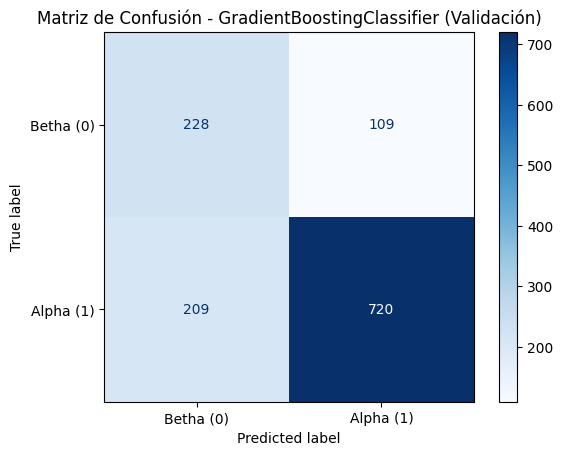


Valores de la Matriz de Confusión:
           Betha (0)  Alpha (1)
Betha (0)        228        109
Alpha (1)        209        720


In [17]:
# Matriz de Confusión en el Conjunto de Validación

# Realizo predicciones en el conjunto de VALIDACIÓN
# Uso el modelo optimizado que se ajustó en la celda anterior
y_val_pred = best_model.predict(X_val)

# Genero la matriz de confusión
cm = confusion_matrix(y_val, y_val_pred)

# matriz de confusión
# Defino las etiquetas de las clases (Alpha=1, Betha=0)
class_labels = ['Betha (0)', 'Alpha (1)']

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=class_labels
)

plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title(f'Matriz de Confusión - {best_model.__class__.__name__} (Validación)')
plt.show()

# Imprimo los valores numéricos
print("\nValores de la Matriz de Confusión:")
print(pd.DataFrame(cm, index=class_labels, columns=class_labels))


MÉTRICAS EN VALIDACIÓN (Umbral = 0.1795)
Accuracy:  0.7852
Precision: 0.8022
Recall:    0.9386
F1 Score:  0.8651
AUC:       0.8152


<Figure size 600x600 with 0 Axes>

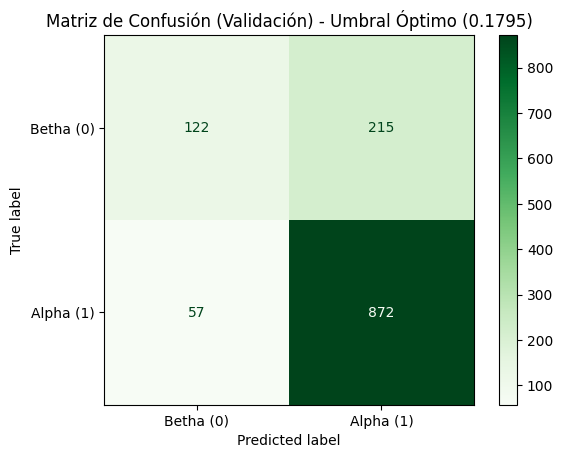


Valores de la Matriz de Confusión (Validación):
           Betha (0)  Alpha (1)
Betha (0)        122        215
Alpha (1)         57        872


In [18]:
# Matriz de Confusión y Métricas (Validación con Umbral Óptimo)
# Probabilidades de clase positiva
y_val_proba = best_model.predict_proba(X_val)[:, 1]

# Clasifico usando el umbral óptimo hallado (por ejemplo, 0.1795)
best_thr_val = 0.1795
y_val_pred_thr = (y_val_proba >= best_thr_val).astype(int)

# Calculo métricas principales
acc_val = accuracy_score(y_val, y_val_pred_thr)
prec_val = precision_score(y_val, y_val_pred_thr)
rec_val = recall_score(y_val, y_val_pred_thr)
f1_val = f1_score(y_val, y_val_pred_thr)
auc_val = roc_auc_score(y_val, y_val_proba)

# Métricas
print(f"\nMÉTRICAS EN VALIDACIÓN (Umbral = {best_thr_val:.4f})")
print(f"Accuracy:  {acc_val:.4f}")
print(f"Precision: {prec_val:.4f}")
print(f"Recall:    {rec_val:.4f}")
print(f"F1 Score:  {f1_val:.4f}")
print(f"AUC:       {auc_val:.4f}")

# Matriz de Confusión con umbral ajustado
cm_thr = confusion_matrix(y_val, y_val_pred_thr)
class_labels = ['Betha (0)', 'Alpha (1)']

disp = ConfusionMatrixDisplay(confusion_matrix=cm_thr, display_labels=class_labels)

plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Greens, values_format='d')
plt.title(f"Matriz de Confusión (Validación) - Umbral Óptimo ({best_thr_val:.4f})")
plt.show()

# Valores
print("\nValores de la Matriz de Confusión (Validación):")
print(pd.DataFrame(cm_thr, index=class_labels, columns=class_labels))


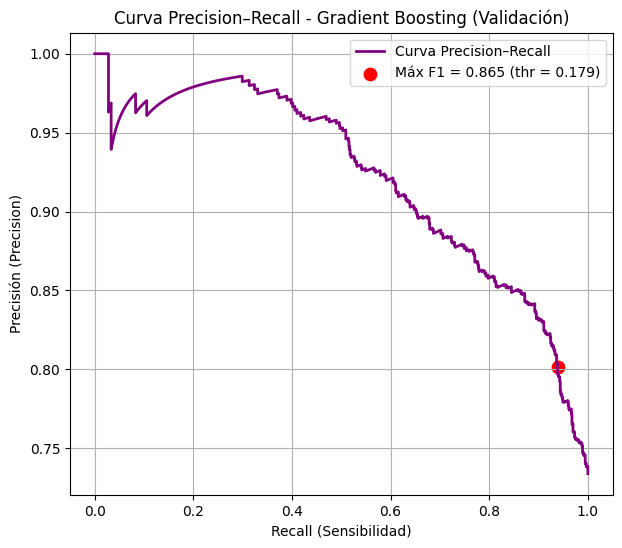

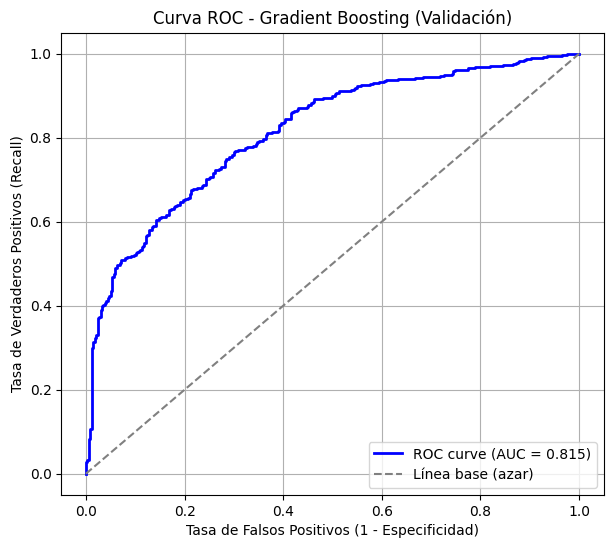

In [19]:
# Curvas ROC y Precision–Recall (VALIDACIÓN)

# Probabilidades de la clase positiva (Alpha = 1)
y_val_proba = best_model.predict_proba(X_val)[:, 1]

# CURVA PRECISION–RECALL
prec, rec, thr = precision_recall_curve(y_val, y_val_proba)
f1_vals = 2 * (prec * rec) / (prec + rec + 1e-12)

# Umbral óptimo (el que encontraste antes)
best_thr_val = 0.1795
best_idx = np.argmin(np.abs(thr - best_thr_val))
f1_max = f1_vals[best_idx]

plt.figure(figsize=(7, 6))
plt.plot(rec, prec, color='purple', lw=2, label='Curva Precision–Recall')
plt.scatter(rec[best_idx], prec[best_idx], color='red', s=80,
            label=f'Máx F1 = {f1_max:.3f} (thr = {best_thr_val:.3f})')
plt.title("Curva Precision–Recall - Gradient Boosting (Validación)")
plt.xlabel("Recall (Sensibilidad)")
plt.ylabel("Precisión (Precision)")
plt.legend()
plt.grid(True)
plt.show()

# Curva ROC (Receiver Operating Characteristic)
fpr, tpr, roc_thr = roc_curve(y_val, y_val_proba)
roc_auc = roc_auc_score(y_val, y_val_proba)

plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Línea base (azar)')
plt.title("Curva ROC - Gradient Boosting (Validación)")
plt.xlabel("Tasa de Falsos Positivos (1 - Especificidad)")
plt.ylabel("Tasa de Verdaderos Positivos (Recall)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()



=== MÉTRICAS FINALES DEL MODELO OPTIMIZADO ===
Accuracy:  0.7557
Precision: 0.8632
Recall:    0.7930
F1 Score:  0.8266
AUC:       0.8267


<Figure size 600x600 with 0 Axes>

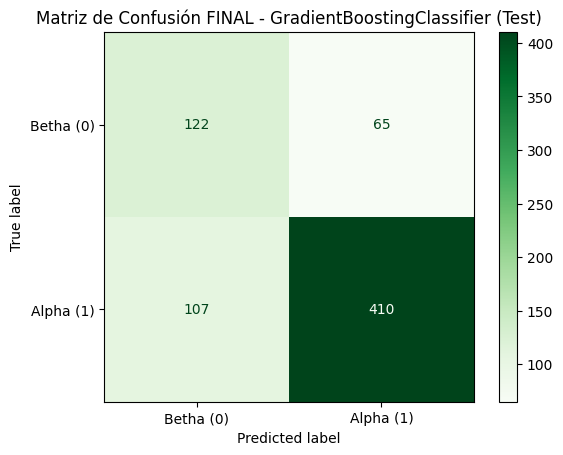


Valores de la Matriz de Confusión (X_test):
           Betha (0)  Alpha (1)
Betha (0)        122         65
Alpha (1)        107        410


In [20]:
# Evaluación final en testeo

# Realizo predicciones
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

# Calculo Métricas Finales
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

print("\n=== MÉTRICAS FINALES DEL MODELO OPTIMIZADO ===")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"AUC:       {auc:.4f}")

# Genero y Mostrar la Matriz de Confusión FINAL
cm = confusion_matrix(y_test, y_pred)

# Alpha=1 y Betha=0
class_labels = ['Betha (0)', 'Alpha (1)']

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=class_labels
)

# gráfica
plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Greens, values_format='d')
plt.title(f'Matriz de Confusión FINAL - {best_model.__class__.__name__} (Test)')
plt.show()

# matriz de confusión
print("\nValores de la Matriz de Confusión (X_test):")
print(pd.DataFrame(cm, index=class_labels, columns=class_labels))


Umbral Óptimo (Validación) - Gradient Boosting 
Mejor Umbral F1: 0.2294
F1 Score Máximo en Validación: 0.8702

=== MÉTRICAS FINALES DEL GRADIENT BOOSTING (Umbral Optimizado) ===
Accuracy:  0.7841
Precision: 0.8130
Recall:    0.9168
F1 Score:  0.8618
AUC:       0.8267
---------------------------------------------


<Figure size 600x600 with 0 Axes>

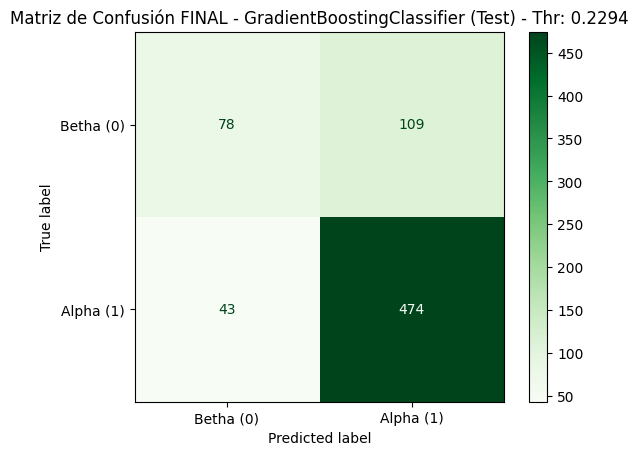


Valores de la Matriz de Confusión (X_test con Umbral Optimizado):
           Betha (0)  Alpha (1)
Betha (0)         78        109
Alpha (1)         43        474


In [21]:
# Evaluación FINAL con Umbral Óptimo (Gradient Boosting)

# Umbral Óptimo en VALIDACIÓN
# Probabilidades de la clase positiva (1) en el conjunto de validación
y_val_proba = best_model.predict_proba(X_val)[:, 1]

#curva Precision-Recall
prec, rec, thr = precision_recall_curve(y_val, y_val_proba)

# F1 Score para cada umbral
f1_vals = 2 * (prec * rec) / (prec + rec + 1e-12) # 1e-12 para evitar división por cero

# índice del F1 Score más alto
best_idx = argmax(f1_vals)

# El mejor umbral es el correspondiente al F1 Score más alto
best_thr_gb = thr[best_idx]
f1_val_max = f1_vals[best_idx]

print("\nUmbral Óptimo (Validación) - Gradient Boosting ")
print(f"Mejor Umbral F1: {best_thr_gb:.4f}")
print(f"F1 Score Máximo en Validación: {f1_val_max:.4f}")

# 2. Evaluación FINAL en TEST con el Umbral Óptimo
# Probabilidades de la clase positiva (1) en el conjunto de test
y_test_proba = best_model.predict_proba(X_test)[:, 1]

# Clasifico usando el umbral óptimo
y_test_pred_best = (y_test_proba >= best_thr_gb).astype(int)

# 3. Calculo Métricas Finales
acc = accuracy_score(y_test, y_test_pred_best)
prec = precision_score(y_test, y_test_pred_best)
rec = recall_score(y_test, y_test_pred_best)
f1 = f1_score(y_test, y_test_pred_best)
auc = roc_auc_score(y_test, y_test_proba) # AUC no depende del umbral

print("\n=== MÉTRICAS FINALES DEL GRADIENT BOOSTING (Umbral Optimizado) ===")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"AUC:       {auc:.4f}")
print("---------------------------------------------")

# Genero la Matriz de Confusión FINAL
cm = confusion_matrix(y_test, y_test_pred_best)
class_labels = ['Betha (0)', 'Alpha (1)']

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=class_labels
)

plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Greens, values_format='d')
plt.title(f'Matriz de Confusión FINAL - {best_model.__class__.__name__} (Test) - Thr: {best_thr_gb:.4f}')
plt.show()

print("\nValores de la Matriz de Confusión (X_test con Umbral Optimizado):")
print(pd.DataFrame(cm, index=class_labels, columns=class_labels))


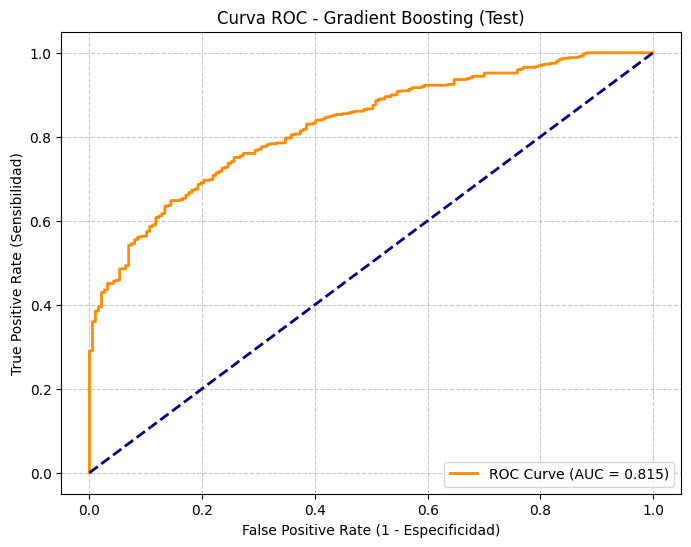

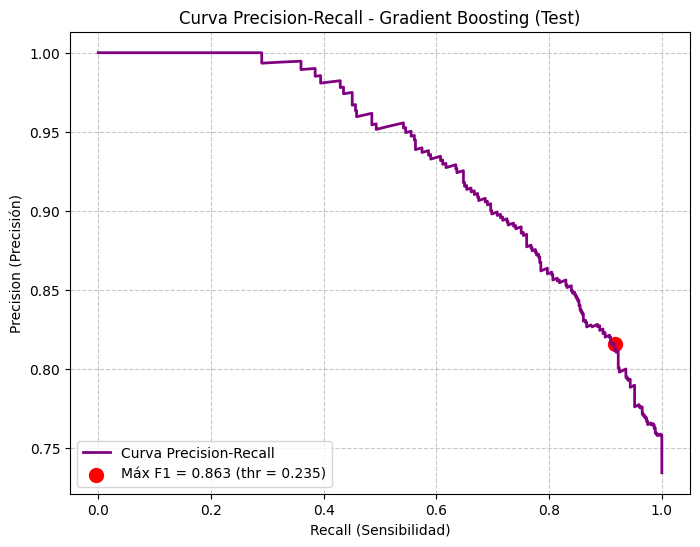


💡 Interpretación de las curvas:
- La curva ROC mide la capacidad general del modelo para separar las clases (AUC = 0.815).
- La curva Precision-Recall es más informativa cuando hay desbalance de clases.
- El punto rojo indica el umbral con el mejor F1 en el conjunto de test.


In [22]:
#Curvas ROC y Precision-Recall (Evaluación Final)

# Curva ROC
fpr, tpr, roc_thr = roc_curve(y_test, y_test_proba)
auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (1 - Especificidad)')
plt.ylabel('True Positive Rate (Sensibilidad)')
plt.title('Curva ROC - Gradient Boosting (Test)')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Curva Precision-Recall 
precision, recall, pr_thr = precision_recall_curve(y_test, y_test_proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-12)
best_idx_pr = np.argmax(f1_scores)
best_thr_pr = pr_thr[best_idx_pr]

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='purple', lw=2,
         label='Curva Precision-Recall')
plt.scatter(
    recall[best_idx_pr], precision[best_idx_pr],
    color='red', s=100,
    label=f'Máx F1 = {f1_scores[best_idx_pr]:.3f} (thr = {best_thr_pr:.3f})'
)
plt.xlabel('Recall (Sensibilidad)')
plt.ylabel('Precision (Precisión)')
plt.title('Curva Precision-Recall - Gradient Boosting (Test)')
plt.legend(loc='lower left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Interpretación adicional
print("\n💡 Interpretación de las curvas:")
print("- La curva ROC mide la capacidad general del modelo para separar las clases (AUC = %.3f)." % roc_auc)
print("- La curva Precision-Recall es más informativa cuando hay desbalance de clases.")
print("- El punto rojo indica el umbral con el mejor F1 en el conjunto de test.")



=== TOP 15 VARIABLES MÁS IMPORTANTES ===
                                  Feature  Importance
1                                  Demand    0.227197
0                                 Charges    0.220958
13                      Contract_Two year    0.199664
12                      Contract_One year    0.130077
16         PaymentMethod_Electronic check    0.059157
14                   PaperlessBilling_Yes    0.035693
11                        TechSupport_Yes    0.016735
2                            SeniorCity_1    0.015540
6                            Service2_Yes    0.013727
8                        OnlineBackup_Yes    0.012258
7                            Security_Yes    0.011094
15  PaymentMethod_Credit card (automatic)    0.010601
9                    DeviceProtection_Yes    0.010178
17             PaymentMethod_Mailed check    0.009824
3                             Partner_Yes    0.009018


C:\Users\Acer\AppData\Local\Temp\ipykernel_31736\577695181.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


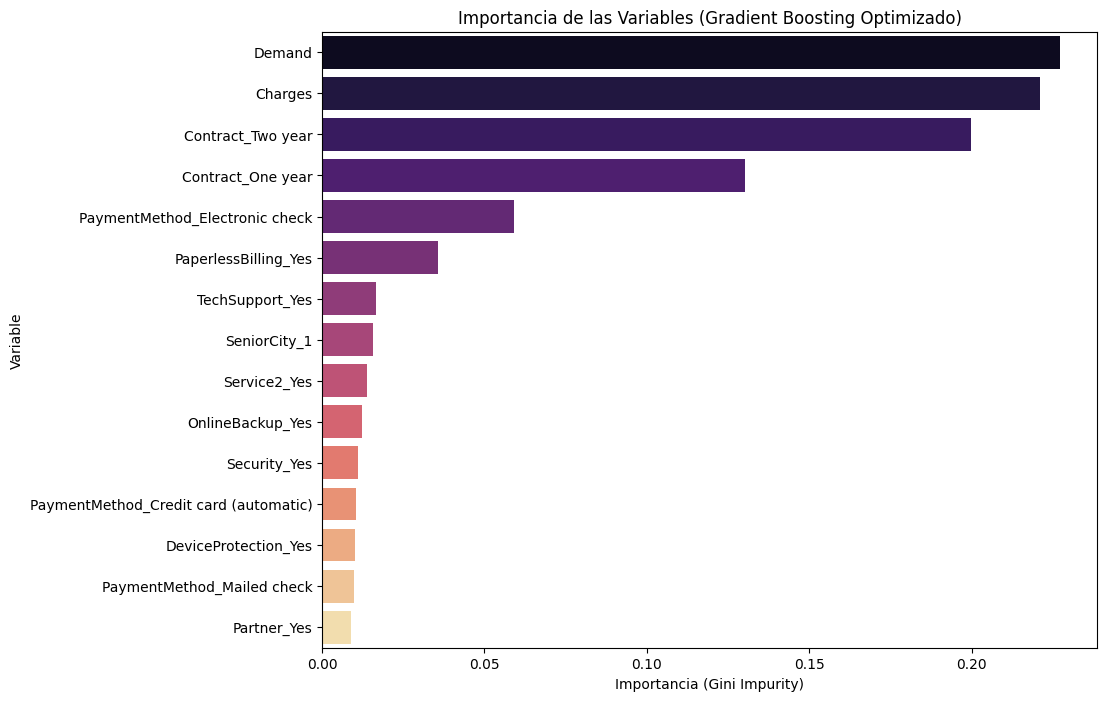

In [23]:
# Importancia de las Variables (Feature Importance) del train

# mportancia de las variables
importances = best_model.feature_importances_
feature_names = X_train_resampled.columns

# DF
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\n=== TOP 15 VARIABLES MÁS IMPORTANTES ===")
print(feature_importance_df.head(15))

plt.figure(figsize=(10, 8))
sns.barplot(
    x='Importance', 
    y='Feature', 
    data=feature_importance_df.head(15), 
    palette='magma'
)
plt.title('Importancia de las Variables (Gradient Boosting Optimizado)')
plt.xlabel('Importancia (Gini Impurity)')
plt.ylabel('Variable')
plt.show()

In [46]:
# Exportar el modelo, umbral y lista de features para la API
numeric_features = ['Charges', 'Demand'] 

categorical_features_ORIGINAL = [
    'Service1', 'Service2', 'Multiple', 'Security', 'OnlineBackup', 'DeviceProtection', 
    'StreamingTV', 'StreamingMovies', 'Contract', 'Payment'
]

# 2. Obtenemos la lista final de columnas que el modelo espera:
final_feature_names = X_train_resampled.columns.tolist() 

# 3. Crear el bundle final con todas las variables requeridas
bundle = {
    "model": best_model,
    "best_threshold": best_thr_gb,
    "feature_names": final_feature_names, 
    "numeric_features": numeric_features, 
    "categorical_features_ORIGINAL": categorical_features_ORIGINAL, 
    "scaler_obj": scaler # El objeto 'scaler' fitado (crítico para la API)
}

# 4. Guardar el bundle
joblib.dump(bundle, "ClasificacionAlphaBetha.pkl")
print("\n✅ Modelo, Umbral y Lista de Features exportados para la API. ¡LISTO!")


✅ Modelo, Umbral y Lista de Features exportados para la API. ¡LISTO!


In [ ]:
# PREDICCIÓN FINAL 

# ARGA DE DEPENDENCIAS Y DATOS NUEVOS 
try:
    # Cargar datos nuevos (Asumiendo que el separador es ';')
    df_raw = pd.read_csv("to_predict.csv", sep=';') 

    # argar el bundle exportado (CRÍTICO: Define todas las variables)
    bundle = joblib.load("ClasificacionAlphaBetha.pkl")
    model = bundle['model']
    scaler = bundle['scaler_obj']
    best_thr_gb = bundle['best_threshold']
    expected_features = bundle['feature_names']  # Las 18 columnas finales
    numeric_features = bundle['numeric_features'] # ['Charges', 'Demand']
    
except FileNotFoundError:
    print("❌ ERROR: El archivo 'to_predict.csv' o 'ClasificacionAlphaBetha.pkl' no se encontró.")
    raise
except Exception as e:
    print(f"❌ ERROR de carga: {e}")
    raise

print(f"✅ Bundle cargado. Filas iniciales a evaluar: {len(df_raw)}")

# --- 2. PREPROCESAMIENTO: Limpieza Estricta y Mapeo ---

# Usamos df_new como la versión limpia y final
df_new = df_raw.copy() 

# A. Limpieza Inicial y Conversión
cols_to_drop_new = ['Class']
df_new.drop(columns=cols_to_drop_new, errors='ignore', inplace=True) 

# Conversión a numérico (Genera NaN si hay texto)
df_new[numeric_features] = df_new[numeric_features].apply(pd.to_numeric, errors='coerce')

# B. LIMPIEZA ESTRICTA: Descartamos cualquier fila con NaN
rows_before_drop = len(df_new)
df_new.dropna(inplace=True) 
rows_after_drop = len(df_new)

if rows_after_drop < rows_before_drop:
    print(f"⚠️ Se descartaron {rows_before_drop - rows_after_drop} filas incompletas y NO serán incluidas en 'resultados.xlsx'.")

if len(df_new) == 0:
    print("❌ ADVERTENCIA: No quedan muestras válidas para predecir después de la limpieza. No se creará 'resultados.xlsx'.")
else:
    # 🛑 PASO CLAVE 2: Usamos autoID como índice temporal
    df_new.set_index('autoID', inplace=True) 
    
    # C. CREACIÓN DEL DATAFRAME PROCESADO (X_processed) con valores 0
    X_new_processed = pd.DataFrame(0, index=df_new.index, columns=expected_features)

    # D. Mapeo Manual (Llenado de 1s en las columnas categóricas)
    X_new_processed[numeric_features] = df_new[numeric_features] # Rellenamos valores numéricos

    # Mapeamos variables binarias
    X_new_processed['SeniorCity_1'] = (df_new['SeniorCity'] == 1).astype(int)
    X_new_processed['Partner_Yes'] = (df_new['Partner'] == 'Yes').astype(int)
    X_new_processed['Dependents_Yes'] = (df_new['Dependents'] == 'Yes').astype(int)
    X_new_processed['Service1_Yes'] = (df_new['Service1'] == 'Yes').astype(int)
    X_new_processed['Service2_Yes'] = (df_new['Service2'] == 'Yes').astype(int)
    X_new_processed['PaperlessBilling_Yes'] = (df_new['PaperlessBilling'] == 'Yes').astype(int)

    # Mapeo de variables multi-categoría
    X_new_processed['Security_Yes'] = (df_new['Security'] == 'Yes').astype(int)
    X_new_processed['OnlineBackup_Yes'] = (df_new['OnlineBackup'] == 'Yes').astype(int)
    X_new_processed['DeviceProtection_Yes'] = (df_new['DeviceProtection'] == 'Yes').astype(int)

    # TechSupport (3 valores originales -> 2 columnas dummy)
    X_new_processed['TechSupport_Yes'] = (df_new['TechSupport'] == 'Yes').astype(int)
    X_new_processed['TechSupport_No internet service'] = (df_new['TechSupport'] == 'No internet service').astype(int)

    # Contract (3 valores originales -> 2 columnas dummy)
    X_new_processed['Contract_One year'] = (df_new['Contract'] == 'One year').astype(int)
    X_new_processed['Contract_Two year'] = (df_new['Contract'] == 'Two year').astype(int)

    # PaymentMethod (4 valores originales -> 3 columnas dummy)
    X_new_processed['PaymentMethod_Credit card (automatic)'] = (df_new['PaymentMethod'] == 'Credit card (automatic)').astype(int)
    X_new_processed['PaymentMethod_Electronic check'] = (df_new['PaymentMethod'] == 'Electronic check').astype(int)
    X_new_processed['PaymentMethod_Mailed check'] = (df_new['PaymentMethod'] == 'Mailed check').astype(int)

    # E. Escalado
    X_new_processed[numeric_features] = scaler.transform(X_new_processed[numeric_features])

    # F. Verificación
    if X_new_processed.shape[1] != len(expected_features):
        print(f"❌ Error CRÍTICO: Columnas procesadas ({X_new_processed.shape[1]}) NO coinciden con las esperadas ({len(expected_features)}).")


    # --- 3. PREDICCIÓN Y RESULTADOS FINALES ---
    print("\n✅ Iniciando predicciones...")
    y_proba_new = model.predict_proba(X_new_processed)[:, 1]
    y_pred_new = (y_proba_new >= best_thr_gb).astype(int)

    # Crear el DataFrame de resultados (contiene solo las filas predichas)
    df_results = df_new.copy() 
    df_results['Probabilidad_Alpha'] = y_proba_new
    
    # 🛑 CORRECCIÓN SOLICITADA: Nombrar la columna de predicción como 'Class'
    df_results['Class'] = pd.Series(y_pred_new, index=df_new.index).map({1: 'Alpha', 0: 'Betha'})

    print("\n=== PREDICCIONES FINALIZADAS ===")
    print(f"Umbral Óptimo Usado: {best_thr_gb:.4f}")
    print("------------------------------------------")
    
    # Preparamos el DF para la exportación (reseteamos el autoID para que sea una columna)
    df_to_export = df_results.reset_index()
    print(df_to_export)

    # 💾 EXPORTACIÓN A EXCEL
    try:
        df_to_export.to_excel("to_predict.xlsx", index=False)
        print("\n✅ DataFrame exportado exitosamente a 'resultados.xlsx'. Contiene solo registros completos.")
    except Exception as e:
        print(f"\n❌ Error al exportar a Excel: {e}")

✅ Bundle cargado. Filas iniciales a evaluar: 4
⚠️ Se descartaron 1 filas incompletas y NO serán incluidas en 'resultados.xlsx'.

✅ Iniciando predicciones...

=== PREDICCIONES FINALIZADAS ===
Umbral Óptimo Usado: 0.2294
------------------------------------------
       autoID  SeniorCity Partner Dependents Service1 Service2  \
0  9695-TERGH         0.0      No         No      Yes       No   
1  5247-VRIOW         0.0      No         No      Yes       No   
2  5731-DDJUB         0.0      No         No      Yes       No   

              Security         OnlineBackup     DeviceProtection  \
0                  Yes                   No                   No   
1                  Yes                   No                   No   
2  No internet service  No internet service  No internet service   

           TechSupport        Contract PaperlessBilling  \
0                   No  Month-to-month              Yes   
1                  Yes  Month-to-month               No   
2  No internet service 